In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import scipy
from scipy import integrate

In [2]:
# Collect data from file
def collect_data_float(filename):
    with open(filename) as file:
        lines = file.readlines()
        lines = [line.rstrip() for line in lines]
        # Change strings to floats
        lines = [float(x) for x in lines]
    return lines



In [3]:
# Collecting the data for our initial file
data = collect_data_float('datafile-exp.txt')

In [4]:
# Printing the different data characteristics, to ensure there wont be an issue
# when running it
print(data[0])
print(len(data))
print(type(data[0]))

4.30037022522614
10000
<class 'float'>


In [5]:
# Convert the data to float, as currently its in string
# That has been put into the function to make sure I dont have to repeat code later
#data = [float(x) for x in data]

In [6]:
def hist(data, title):
    
    # Plot histograms
    plt.figure(figsize=(10,10))
    plt.hist(data, bins = 100)
        
    plt.title("Histogram of " + str(title))
    #plt.savefig(str(data_type[Type]) + '_Full_Histogram.pdf')
    plt.show()

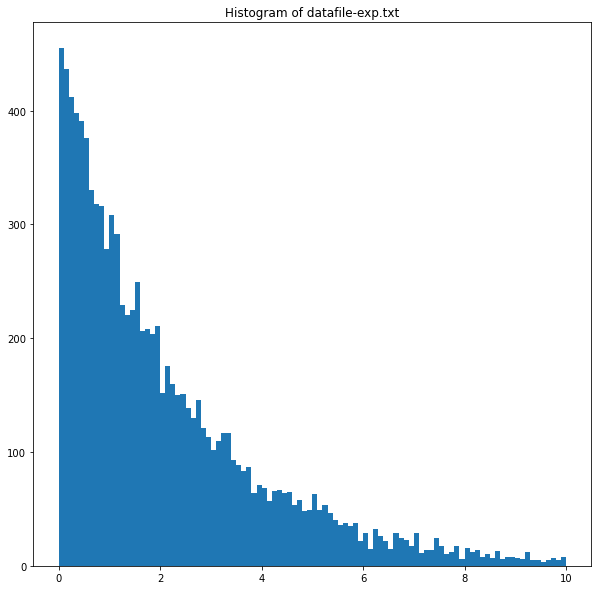

In [7]:
# Plot the data as a histogram
hist(data, "datafile-exp.txt")

This is a histogram plot for our data as provided in file 'datafile-exp.txt'. It shows an exponential decay.

In [9]:
# Producing the Maximum likelihood fit functions for this data

# Define the exponential
def exponential(x, lifetime):
    y = np.exp(-x/lifetime)
    return y
    

# Define the maximum likelihood fitting method
def nll(lifetime):
    
    # Create list
    y = []
    
    # Give data points
    x = np.array(data)

    # Calculate the y
    y = exponential(x, lifetime)
    
    # Calculate the normalisation over our exponential range of 0->10
    norm = lifetime * (np.exp(0) - np.exp(-10/lifetime))
    # Apply normalisation to our data
    y_norm = y / norm
    
    # Apply log
    y_res = np.log(y_norm)
    
    # sum and apply negative to get nll
    nll = -np.sum(y_res)
    
    return nll

The normalisation is from the notes for an exponential across a specific range:

$\int_{thigh}^{tlow} exp(-\frac{t}{\tau})) = \tau \times \left [ exp(-\frac{t_{tlow}}{\tau})) - exp(-\frac{t_{thigh}}{\tau})) \right ]$

Where we set tlow to 0 and thigh to 10

In [10]:
# Taken from the notes from two weeks ago to show iminuit results
def showIminuitResult( paramNames, theMinuit ):
    
    #averageList = {}

    fstr = "{0:8.4f}"
    for pn in paramNames :
        val = theMinuit.values[pn]
        err = theMinuit.errors[pn]
        print('\t','{:15s}'.format(pn), ':  \t', fstr.format(val), ' +/- ', fstr.format(err))
    print('\n')


In [11]:
# Create the minuit object to calculate the fit of our exponential function
# over our data
m = Minuit(nll, lifetime = 2)
m.errors = 0.5
m.errordef = 0.5

# Fit and show results
result = m.migrad()

showIminuitResult(("lifetime",), m)

	 lifetime        :  	   2.2043  +/-    0.0250




In [12]:
print("Lifetime value: ")
print(str(m.values["lifetime",]))
print("Lifetime error: ")
print(str(m.errors["lifetime",]))

Lifetime value: 
[2.204334094034168]
Lifetime error: 
[0.02504301368724254]


This result is in good agreement with the true value of 2.2 for the lifetime.

## Task 2
### datafile-expresonance.txt

In [13]:
data_expr = collect_data_float('datafile-expresonance.txt')

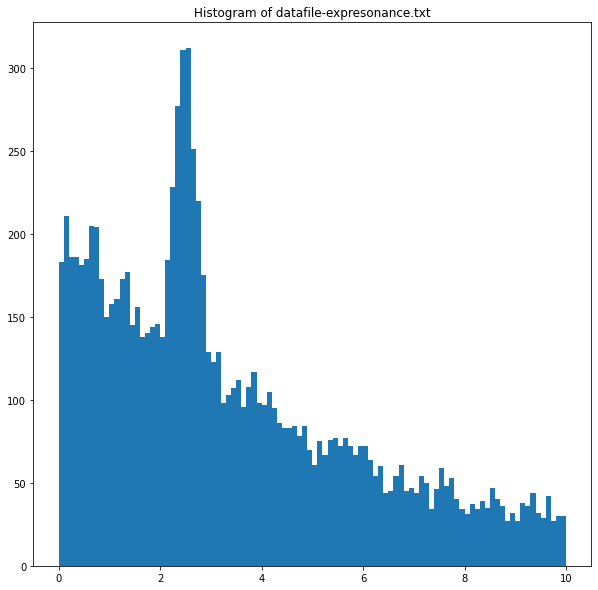

In [14]:
hist(data_expr, "datafile-expresonance.txt")

This is the histogram plot for our second data sample, with the gaussian distribution clearly prevalent in our exponential decay.

In [21]:
# We will reuse the previous exponential parameter with lifetime

# Define a new gaussian
def gaussian(x, mu):
    # fix sigma for 0.2, should sigma be 0.1? We're considering 
    sigma = 0.2
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))


# Define a combined exponential and gaussian function for NLL
def nll_exp_gauss(mu, lifetime, F):
    # F is our fraction for how much of the distribution is gaussian/exponential
    
    # Take data
    x = np.array(data_expr)
    
    # Calculating y for the EXPONENT
    
    # Calculate the y
    y = exponential(x, lifetime)
    # Calculate the normalisation over our exponential over range 0->10
    norm = lifetime * (np.exp(0) - np.exp(-10/lifetime))
    y_norm = y / norm
    
    # Calculating y for the GAUSSIAN
    
    # Calculate the y
    yg = gaussian(x, mu)
    # normalise our gaussian, where 0.2 is the sigma
    yg = yg * 1/(np.sqrt(2*np.pi*0.2**2))
    #print(yg)
    
    # Take joint likelihood for the gaussian and exponential
    joint1 = [i * (1-F) for i in yg]
    joint2 = [i * F for i in y_norm]
    joint = np.array([sum(x) for x in zip(joint1, joint2)])
    
    
    # Take log of joint
    y_log = np.log(joint)
    
    # Take negative sum
    nll = -np.sum(y_log)
    
    return nll
    

Here we get our combined likelihood using the individual likelihoods multiplied by a fraction and added to one another for the Gaussian and Exponential:

$L_{total} = (F)L_{exp} + (1-F)L_{gaussian}$

Where the fraction is one of the parameters controlled by the minimiser.
We normalise the exponential the same way as before, and here we normalise the gaussian in the default form:

$ Normalised = Gaussian \times \frac{1}{\sqrt{2\pi\sigma^2}} $

This works just fine over our limited range even when this is technically a normalisation across 0 to infinity

In [22]:
# Create the minuit object, with initial guesses
n = Minuit(nll_exp_gauss, mu = 2, lifetime = 2, F = 0.8)
# Take the 'first step' to be 0.5 for each value
n.errors = [0.5, 0.5, 0.5]
# Define for NLL
n.errordef = 0.5
# Set limits
n.limits = [[1,9], [0, 10], [0, 1]]

# Fit and show results
result = n.migrad()

# Show results
showIminuitResult(("mu", "lifetime", "F"), n)

	 mu              :  	   2.4998  +/-    0.0118
	 lifetime        :  	   5.0429  +/-    0.1027
	 F               :  	   0.9029  +/-    0.0045




So we get results that agree quite well with the true results for mu, lifetime and F (2.5, 5.0, and 0.9). This shows that our method works as expected for the data.

In [23]:
# Correlation between the different elements. Purely for review.
n.covariance.correlation()

,mu,lifetime,F
mu,1,-0.0346,0.0158
lifetime,-0.0346,1,-0.0968
F,0.0158,-0.0968,1
